## Quantification of antibody nativeness using LSTM network

As a final task, a Long Short-Term Memory network was used to quantify the nativeness of given sequences. The architecture is described in this [paper](https://academic.oup.com/peds/article/32/7/347/5554642?login=false), and the code was downloaded from this [GitHub repository](https://github.com/vkola-lab/peds2019).

The underlying assumption is that, given an input sequence, a well-trained model would be able to predict any residue by learning information from its neighbors. The output of the model is the averaged sum of negative logarithms of all conditional probabilities (see paper); thus, lower scores indicate a higher degree of nativeness.

The model takes files containing sequences in plain text format, delimited by one line-break.

In [2]:
import sys

# add path to the folder containing the LSTM model
sys.path.append('/home/enrico/Desktop/lecture_notes/erasmus/bioinformatics/project/peds2019')

In [3]:
from ablstm import ModelLSTM
from Bio import SeqIO
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

/home/enrico/anaconda3/envs/amlfall22/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [104]:
# parse sequenced aligned with ANARCI numbering

human_seq = [seq.seq for seq in SeqIO.parse("data/alignments/human_hmm_align.fasta", "fasta")]
mouse_seq = [seq.seq for seq in SeqIO.parse("data/alignments/mouse_hmm_align.fasta", "fasta")]

In [120]:
# split the sequences in the following way: 70% train set, 15% validation set, 15% test set

idx_val = round(len(human_seq)*0.7)      # find indices for train/val/test split
idx_test = round(len(human_seq)*0.85)    # 

8497


In [6]:
# prepare input files in plain text format for the LSTM model (only sequences)

lstm_folder = 'data/lstm_model/'

In [ ]:
# split human sequences in train/validation/test sets

with open(f'{lstm_folder}human_seq_train.txt', 'w') as f:
    for seq in human_seq[:idx_val]:
        f.write(f'{seq}\n')

with open(f'{lstm_folder}human_seq_val.txt', 'w') as f:
    for seq in human_seq[idx_val:idx_test]:
        f.write(f'{seq}\n')

with open(f'{lstm_folder}human_seq_test.txt', 'w') as f:
        for seq in human_seq[idx_test:]:
            f.write(f'{seq}\n')


# use the same amount of mouse sequences as validation set

with open(f'{lstm_folder}/mouse_seq.txt', 'w') as f:
    for seq in mouse_seq[idx_test:]:
        f.write(f'{seq}\n')

In [7]:
# define the LSMT model

model = ModelLSTM(
    embedding_dim=64,       # embedding layer dimensions
    hidden_dim=64,          # hidden layer dimension
    device='cuda',          # select GPU as device
    gapped=True,            # gapped=True since the sequences contain gaps "-"
    fixed_len=True          # since all the sequences alignmned with ANARCI has same lenght
)

In [8]:
# define input paths for train and valdiation datasets and fit the model

trn_fn = f'{lstm_folder}human_seq_train.txt'
vld_fn = f'{lstm_folder}human_seq_val.txt'

model.fit(trn_fn=trn_fn, vld_fn=vld_fn, n_epoch=15, save_fp=None)

          (VLD): 100%|| 1499/1499 [00:00<00:00, 5241.07seq/s, loss=0.384044, acc=0.907943]


In [9]:
tst_fn = f'{lstm_folder}human_seq_test.txt'       # define input path for human test set
tst_fn_mouse = f'{lstm_folder}mouse_seq.txt'      # define input path for mouse dataset

human_score = model.eval(fn=tst_fn)                # generate predictions
mouse_score = model.eval(fn=tst_fn_mouse)

100%|| 1500/1500 [00:00<00:00, 4803.37seq/s]


In [10]:
print(human_score)

[0.21559383 0.25203153 0.20611605 ... 0.27314645 0.99283683 0.95259374]


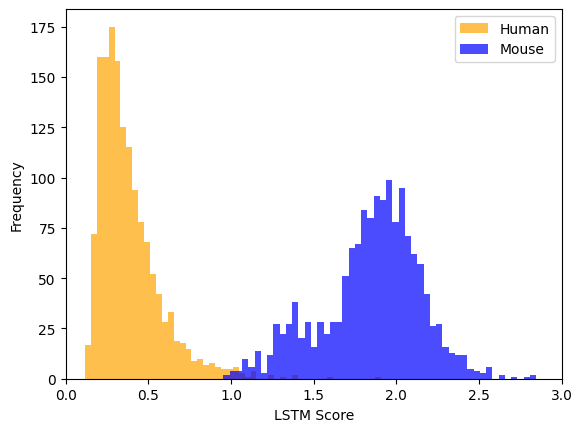

In [11]:
plt.figure()
plt.xlabel('LSTM Score')

ax1 = pd.Series(human_score).plot(kind = 'hist', bins=50, color = 'orange', alpha = 0.7, label = 'Human')
ax2 = pd.Series(mouse_score).plot(kind = 'hist', bins=50, color = 'blue', alpha = 0.7, label = 'Mouse')

plt.xlim([0, 3])

ax1.legend()
ax2.legend()

plt.savefig('data/lstm_model/score_plot.png')
plt.show()


In [184]:
# generate ROC using arbitrary cutoffs
from sklearn.metrics import confusion_matrix

def plot_ROC(h_scores, m_scores):

    def compute_confusion_matrix(dataDf, treshold):
        dataDf['pred'] = np.where(dataDf['scores'] < treshold, 1, 0)
        confMat = confusion_matrix(dataDf['true'], dataDf['pred'])
        return confMat
    
    hDf = pd.DataFrame(h_scores, columns=['scores'])
    hDf['true'] = 1         # positive class is human
    mDf = pd.DataFrame(m_scores, columns=['scores'])
    mDf['true'] = 0

    dataDf = pd.concat([hDf, mDf])
    del(hDf, mDf)
    
    # TPR = TP / (TP + FN)
    # FPR = FP / (FP + TN)

    tpr = []
    fpr = []

    for treshold in np.linspace(0.5, 1.5, 500):
        tn, fp, fn, tp = compute_confusion_matrix(dataDf, treshold).ravel()
        tpr.append(tp / (tp + fn))
        fpr.append(fp / (fp + tn))


    plt.plot(fpr, tpr)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.legend(['mouse'])
    plt.savefig('data/lstm_model/ROC.png')

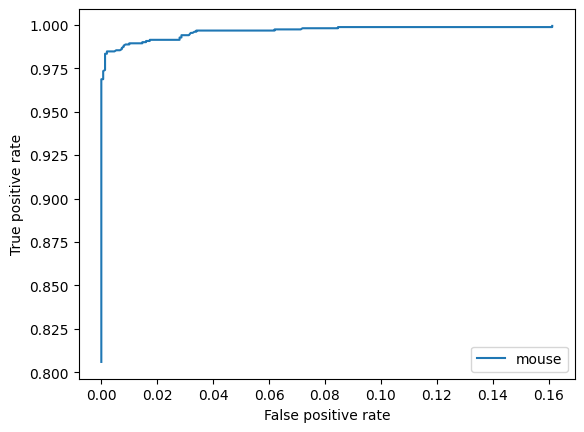

In [185]:
plot_ROC(human_score, mouse_score)

### Plot lstm score vs human germline identity

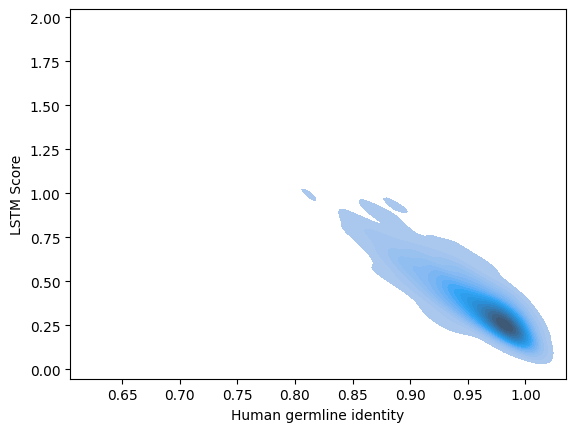

In [182]:
# retrieve numbering csv that has a columns named 'v_identity'
numberingDf = pd.read_csv('data/human_numbering_H.csv')
v_identityDf = numberingDf[['Id', 'v_identity']]
del(numberingDf)

# retrieve IDs from the fasta files obtained from the csv and used to extract the sequence for the lstm model
idDf = pd.Series([int(seq.id) for seq in SeqIO.parse("data/alignments/human_hmm_align.fasta", "fasta")], name = 'Id')

# the output sequences were only the ones belonging to the test set, so from idx_test to the end
idDf = idDf[idx_test:]

# merge series of Ids of scored sequences and df containing Id and v_identity
idDf = pd.merge(idDf, v_identityDf, how='left', on='Id')
idDf['score'] = human_score

kdeplot = sns.kdeplot(data=idDf, x='v_identity', y='score',
            fill=True, levels=20)
kdeplot.set(xlabel = 'Human germline identity', ylabel = 'LSTM Score')
plot_fig = kdeplot.get_figure()
plot_fig.savefig('data/lstm_model/score_vs_identity.png')